In [2]:
# INSTALL MISSING LIBRARIES (This depends on device and GPU used - some stuff may already be satisfied, some may not)
%pip install datasets
%pip install pandas
%pip install scikit-learn

#Import libraries used 
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import pandas as pd
from datasets import Dataset, DatasetDict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 11.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 11.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 11.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 11.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
## check devices

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If CUDA is available, print the GPU name and the device being used
if torch.cuda.is_available():
    # Get the name of the current GPU
    gpu_name = torch.cuda.get_device_name(device)
    print(f"CUDA is available. Using GPU: {gpu_name}")
else:
    print("CUDA is not available. Using CPU.")

# print(device)

CUDA is available. Using GPU: NVIDIA GeForce GTX 1070


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 11.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 11.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Number of training images: 274
Number of validation images: 523
Number of test images: 257
Training dataset class distribution:
Boeing: 144
Airbus: 77
Canadair: 18
Cessna: 10
Embraer: 25
Validation dataset class distribution:
Boeing: 278
Airbus: 134
Canadair: 35
Cessna: 25
Embraer: 51
Test dataset class distribution:
Boeing: 142
Airbus: 71
Canadair: 16
Cessna: 6
Embraer: 22
DataLoaders for selected labels created successfully.
Epoch [1/30], Train Loss: 2.9241, Test Loss: 1.5279, Train Acc: 0.3285, Test Acc: 0.5525, F1 Score: 0.3933
Epoch [2/30], Train Loss: 1.2825, Test Loss: 1.4070, Train Acc: 0.5109, Test Acc: 0.5564, F1 Score: 0.4019
Epoch [3/30], Train Loss: 1.2255, Test L

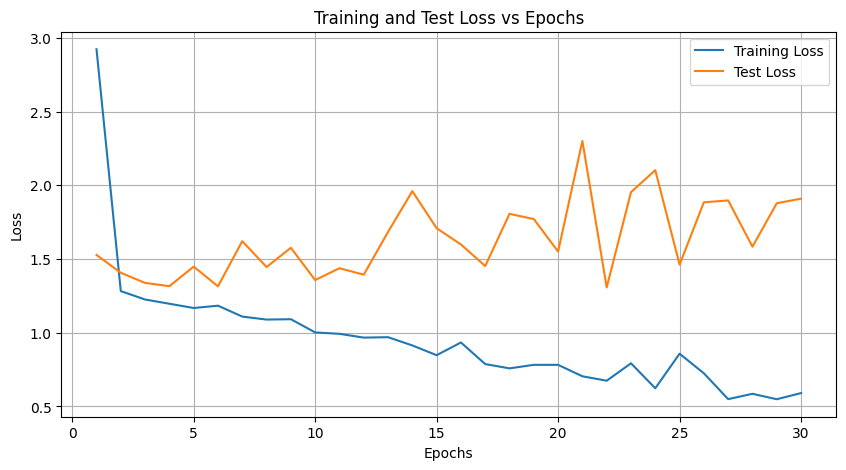

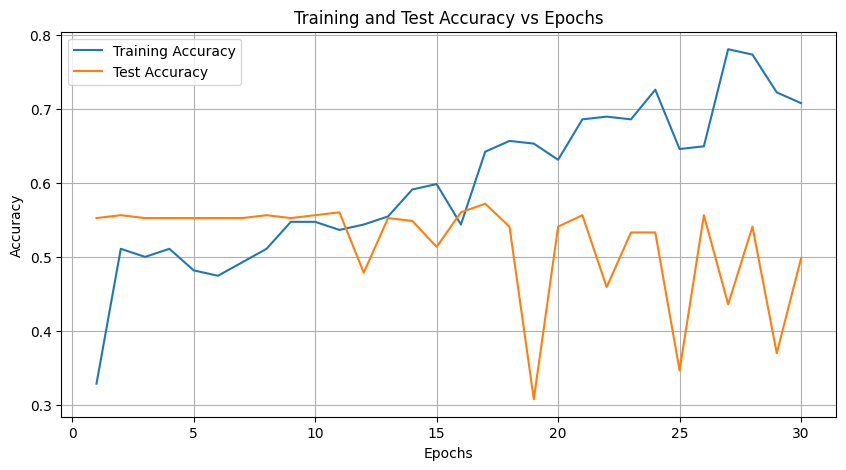

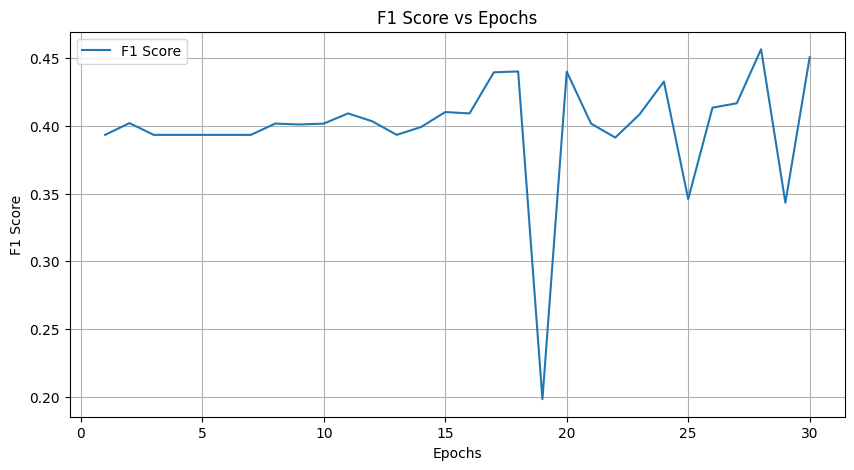

In [5]:
%pip install matplotlib

import os
import time
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from collections import Counter

# Define the folder containing the images
image_folder = './AircraftRecognitionDataset/dataoriginal/images'

# Paths to the text files
train_label_file = './AircraftRecognitionDataset/dataoriginal/images_manufacturer_train.txt'
test_label_file = './AircraftRecognitionDataset/dataoriginal/images_manufacturer_test.txt'
val_label_file = './AircraftRecognitionDataset/dataoriginal/images_manufacturer_trainval.txt'

# Define label mapping
label_mapping = {
    "Boeing": 0,
    "Airbus": 1,
    "ATR": 2,
    "Antonov": 3,
    "BritishAerospace": 4,
    "Beechcraft": 5,
    "LockheedCorporation": 6,
    "DouglasAircraftCompany": 7,
    "Canadair": 8,
    "Cessna": 9,
    "McDonnellDouglas": 10,
    "deHavilland": 11,
    "Robin": 12,
    "Dornier": 13,
    "Embraer": 14,
    "Eurofighter": 15,
    "LockheedMartin": 16,
    "DassaultAviation": 17,
    "Fokker": 18,
    "BombardierAerospace": 19,
    "GulfstreamAerospace": 20,
    "Ilyushin": 21,
    "Fairchild": 22,
    "Piper": 23,
    "CirrusAircraft": 24,
    "Saab": 25,
    "Supermarine": 26,
    "Panavia": 27,
    "Tupolev": 28,
    "Yakovlev": 29
}

def select_balanced_classes(train_file, val_file, test_file, label_mapping, num_classes=5):
    def count_labels(file_path):
        counts = Counter()
        with open(file_path, "r") as f:
            for line in f:
                _, label = line.strip().split(maxsplit=1)
                if label in label_mapping:
                    counts[label] += 1
        return counts

    train_counts = count_labels(train_file)
    val_counts = count_labels(val_file)
    test_counts = count_labels(test_file)

    # Combine counts for all datasets
    combined_counts = {label: train_counts[label] + val_counts[label] + test_counts[label] for label in label_mapping}
    
    # Sort by total count and select top labels
    selected_labels = dict(sorted(combined_counts.items(), key=lambda item: item[1], reverse=True)[:num_classes])
    
    # Map selected labels to indices
    selected_labels = {label: idx for idx, (label, _) in enumerate(selected_labels.items())}

    return selected_labels

# Intelligently select classes based on data distribution
selected_labels = select_balanced_classes(train_label_file, val_label_file, test_label_file, label_mapping)


# Define transformations for image processing
transform = transforms.Compose([
    transforms.RandomRotation(5),    # Random rotation up to 15 degrees
    transforms.Resize((256, 256)),  # Resize to 128x128
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize
])

def filter_data(label_file, selected_labels):
    image_data = []
    labels = []

    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split(maxsplit=1)
            if len(parts) != 2:
                continue  # Skip malformed lines
            filename, label = parts
            if label in selected_labels:
                image_path = os.path.join(image_folder, filename + ".jpg")
                try:
                    if os.path.exists(image_path):
                        image = Image.open(image_path).convert("RGB")
                        image_tensor = transform(image)
                        image_data.append(image_tensor)
                        labels.append(selected_labels[label])
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    # Convert lists to PyTorch tensors
    image_tensor = torch.stack(image_data)
    label_tensor = torch.tensor(labels, dtype=torch.long)

    return image_tensor, label_tensor, labels

# Process training, validation, and test data for selected labels
train_image_tensor, train_label_tensor, train_labels = filter_data(train_label_file, selected_labels)
val_image_tensor, val_label_tensor, val_labels = filter_data(val_label_file, selected_labels)
test_image_tensor, test_label_tensor, test_labels = filter_data(test_label_file, selected_labels)

# Print dataset sizes
print(f"Number of training images: {len(train_image_tensor)}")
print(f"Number of validation images: {len(val_image_tensor)}")
print(f"Number of test images: {len(test_image_tensor)}")

# Print counts for each class in training, validation, and test datasets
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

print("Training dataset class distribution:")
for label, count in train_counts.items():
    print(f"{list(selected_labels.keys())[list(selected_labels.values()).index(label)]}: {count}")

print("Validation dataset class distribution:")
for label, count in val_counts.items():
    print(f"{list(selected_labels.keys())[list(selected_labels.values()).index(label)]}: {count}")

print("Test dataset class distribution:")
for label, count in test_counts.items():
    print(f"{list(selected_labels.keys())[list(selected_labels.values()).index(label)]}: {count}")

# Create TensorDatasets
train_dataset = TensorDataset(train_image_tensor, train_label_tensor)
val_dataset = TensorDataset(val_image_tensor, val_label_tensor)
test_dataset = TensorDataset(test_image_tensor, test_label_tensor)

# Example usage of DataLoader
batch_size = 32  # Decreased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("DataLoaders for selected labels created successfully.")

# Define a simplified CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Updated input size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, len(selected_labels))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 32 * 32)  # Updated reshaping size
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the simplified model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Fixed learning rate

# Lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
f1_scores = []

# Training loop
num_epochs = 30  # Decreased number of epochs
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    test_accuracy = correct_test / total_test
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Store metrics
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}, F1 Score: {f1:.4f}")

print("Training complete.")

# Plotting results
epochs = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_scores, label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epochs')
plt.legend()
plt.grid(True)
plt.show()